# First steps

Make sure to install all libraries used below. For a list of the packages, read requirements.txt in the root directory.

Or simply run the following command:
`pip install -r requirements.txt`

---

In addition to the libraries in requirements.txt, we will also install a user package from https://github.com/LAL/trackml-library

This is the official data loading tool used for the challenge, and will make our lives a lot easier.

> .

The first step is to clone the repository, into a directory of your choice*, as follows:

`git clone https://github.com/LAL/trackml-library`

Next, install the package as user package with pip: 

`pip install --user trackml-library`

That's it! Now you can use the trackml library 	&#x1F389;
___
**NOTE**: if you are using a virtual environment with:
```
export PIP_REQUIRE_VIRTUALENV=true
export PIP_RESPECT_VIRTUALENV=true
```
Then you have to disable these (set to `false`) and restart your shell before installing.
___


*: I suggest moving up one directory and cloning it there. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch

You have to complete some additional steps to download the dataset. The data was part of a kaggle challenge, hosted by CERN. To install the data, follow the steps below

First, make sure you have kaggle installed. `pip install kaggle`

Next, you'll need a kaggle account. Head over to https://www.kaggle.com/, and log in or register.

In order to download the dataset, we need to accept the competition's rules and terms. 
- So, head over to [TrackML kaggle page](https://www.kaggle.com/c/trackml-particle-identification/overview).
- Press 'Late submission', this will open a pop-up window with the rules.
- Finally, accept the rules and terms (after reading them of course :P).

The final step before we can download the data, is to generate an API access token. 
- Head over to [your account setting](https://www.kaggle.com/settings).
- Scroll to the API section and press 'Create New Token'. This will download a file `kaggle.json`.
    - Friendly reminder to NEVER share API keys/tokens. Also make sure you do not accidentally commit them, as they may be stored in your git commit history.
- Finally, move the `kaggle.json` file to the .kaggle/ folder. 
    - If you are using the Kaggle CLI tool, the tool will look for this token at `~/.kaggle/kaggle.json` on Linux, OSX, and other UNIX-based operating systems, and at `C:\Users\<Windows-username>\.kaggle\kaggle.json` on Windows.
    - For Linux/OSX/UNIX users - Move the `kaggle.json` file to the `~/.kaggle/` directory.
    - For Windows users - Move the `kaggle.json` file to the `C:\Users\<Windows-username>\.kaggle\` directory.

That should do it! In case the above does not work, read through 'Getting started' in the [kaggle API documentation](https://www.kaggle.com/docs/api).

## Downloading the dataset
To download the dataset - run the following command, with data/ directory as working directory:
- `kaggle competitions download -c trackml-particle-identification`
- NOTE: This will take some time. The dataset is ~80GB.

If you've done this correctly, the following cell will print the filenames of the dataset.

In [5]:
# !kaggle competitions download -c trackml-particle-identification -p ../data # Download the whole dataset (75 Gb)

!kaggle competitions download trackml-particle-identification -f train_sample.zip -p ../data # Download only small train sample
!mkdir -p ../data/train_sample 
!unzip -qn ../data/train_sample.zip -d ../data/train_sample

train_sample.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
import os
# Change directory to data/ folder in the project root directory
os.chdir("../data/")

_ = [print(filename) for filename in os.listdir()]

train_sample
.gitkeep
train_sample.zip


# TrackML - Particle Tracking 
Kaggle provides the following description to the project (and dataset):

"
To explore what our universe is made of, scientists at CERN are colliding protons, essentially recreating mini big bangs, and meticulously observing these collisions with intricate silicon detectors.

While orchestrating the collisions and observations is already a massive scientific accomplishment, analyzing the enormous amounts of data produced from the experiments is becoming an overwhelming challenge.

Event rates have already reached hundreds of millions of collisions per second, meaning physicists must sift through tens of petabytes of data per year. And, as the resolution of detectors improve, ever better software is needed for real-time pre-processing and filtering of the most promising events, producing even more data.

To help address this problem, a team of Machine Learning experts and physics scientists working at CERN (the world largest high energy physics laboratory), has partnered with Kaggle and prestigious sponsors to answer the question: can machine learning assist high energy physics in discovering and characterizing new particles?
"

## Your research goal

The original competition challenged ML engineers to learn, discover, and analyze the distribution of released particles $X$. They treat the hits as a snapshot, ie. a 3D image.

However, we can add a pseudo-time axis to this dataset, by making an assumption on the hits $X_i$ within a track $i$. If we assume that the particles move away from the collision, the tracks can be viewed as a time-series with 3 spatial dimensions (and the time axis). Let $X_i^v, X_i^w$ be hits in track $X_i$, and let $c$ denote the coordinates of the initial collision. If $d(c, X_i^v) < d(c, X_i^w)$, for some distance function $d$, we say that $X_i^v$ occurs before $X_i^w$.

Each particle has an attribute for the `volume_id`, `layer_id`, `module_id`. These are identifiers for the detector group, detector layer inside the group, and the module inside the layer. We can treat these values as a pseudo-timestep, since certain detectors/layers/modules will be further away from the center of the collision. Alternatively, you could use a discrete distance function as your pseudo-time axis. This decision is up to you; you can choose how you want to inject the time axis $\tau$.

You are tasked with creating a model/framework with parameters $\theta$ that can learn the distribution $P_\theta(X^{t+1}, \tau^{t+1} | X^t, \tau^t)$. If $\tau$ can be inferred from $X$, the learning task is simplified to $P_\theta(X^{t+1}|X^t)$

## The data
<img src="../notebooks/particle_tracking_data.svg" alt="drawing" width="800" style="background-color: white; padding: 100px; padding-left: 50px;"/>

The figure above explains what the different components of the data mean on a high level. For a more in-depth description, read the kaggle [data documentation](https://www.kaggle.com/competitions/trackml-particle-identification/data)

### Data structure

For each independent event, 4 csv files are stored
- event-hits.csv        - has positions of each hit (x,y,z) as well as the ids of the detector group, layer, and module.

- event-cells.csv       - contains the constituent active detector cells that comprise each hit.

- event-particles.csv   - contains the id, initial position, charge, number of hits, and initial momentum for each particle.

- event-truth.csv       - contains the mapping between hits and generating particles and the true particle state at each measured hit. 

The columns and values of each csv are explained in the kaggle [data documentation](https://www.kaggle.com/competitions/trackml-particle-identification/data).

### Trackml basics

Finally, we recommend using the official trackml library for reading the data. There are a lot of helper functions, but the main thing to note is that you can easily get some pandas DataFrames of the hits, cells, particles and truths csvs corresponding to a specified event. Simply call `load_event(prefix)` where prefix is the relative file path, and the event id.

In [7]:
import trackml
from trackml.dataset import load_event


# NOTE: To run this cell, you need to extract the train_sample zip to directory data/train_sample/ if you haven't already.
# This may again take some time.
hits, cells, particles, truth = load_event("../data/train_sample/train_100_events/event000001000")

### Headers

In [8]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [9]:
# Probably not relevant
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [10]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [11]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


### Hits visualization

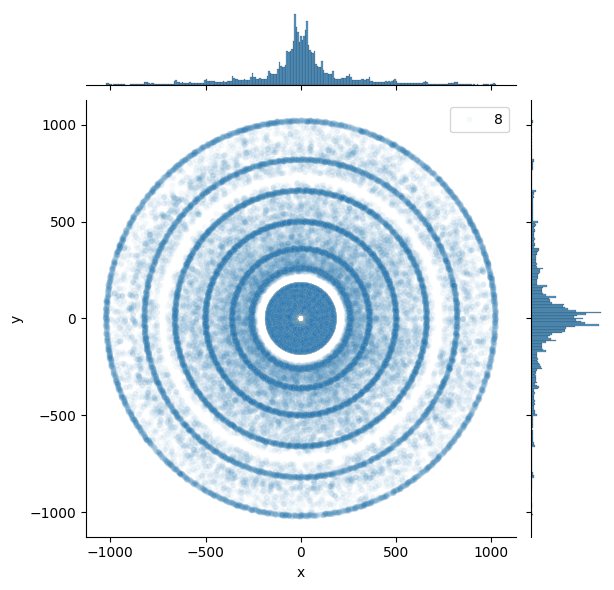

In [13]:
"""Adapted from https://www.kaggle.com/code/hrmello/trackml-datasets-overview"""
sns.jointplot(x = "x", y= "y", data = hits, alpha = 0.05, size = 8);

### Track visualization

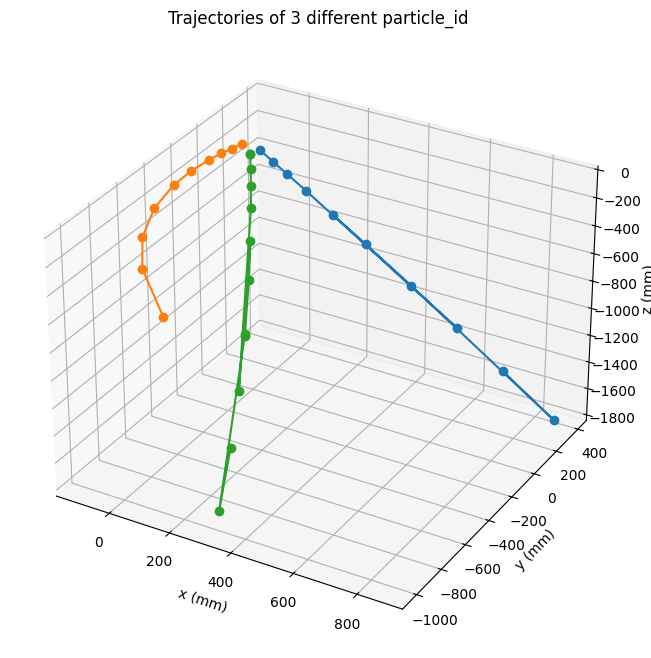

In [14]:
"""Adapted from https://www.kaggle.com/code/hrmello/trackml-datasets-overview"""
#get the information for some particles
truth_0 = truth[truth.particle_id == particles.iloc[20,0]]
truth_1 = truth[truth.particle_id == particles.iloc[10,0]]
truth_2 = truth[truth.particle_id == particles.iloc[5,0]]

#create figure instance
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

#plot each particle's path
ax.plot(
    xs=truth_0.tx,
    ys=truth_0.ty,
    zs=truth_0.tz, marker='o')
ax.plot(
    xs=truth_1.tx,
    ys=truth_1.ty,
    zs=truth_1.tz, marker='o')
ax.plot(
    xs=truth_2.tx,
    ys=truth_2.ty,
    zs=truth_2.tz, marker='o')

ax.set_title('Trajectories of 3 different particle_id')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
plt.show()



# Pseudo-time example
The plot above shows three particle tracks. However, the different points do not have a pseudo-time value associated with them - so this is not yet a time-series.

In the example below, we will use the volume_id as time. 

Note that this is only the detector identifier, and that you probably want to enrich it with the layer/module id's in your own implementation.

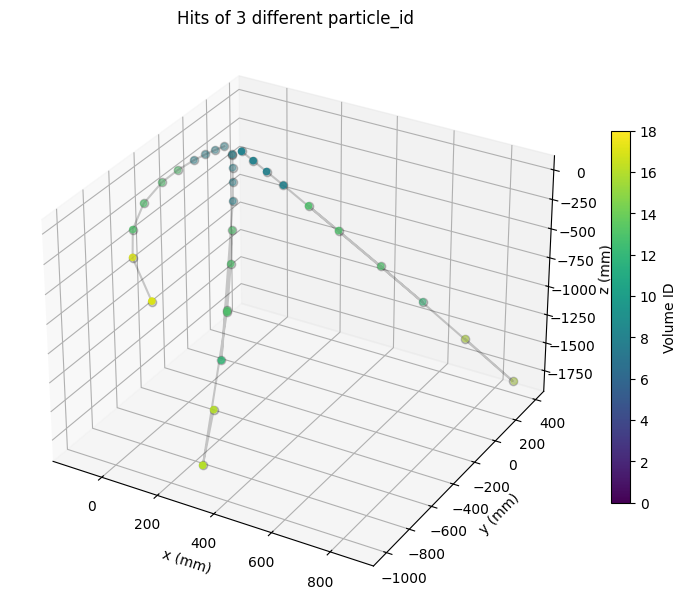

In [15]:
# get detector / layer / module information for the three particles
hits_0 = hits[hits.hit_id.isin(truth_0.hit_id)]
hits_1 = hits[hits.hit_id.isin(truth_1.hit_id)]
hits_2 = hits[hits.hit_id.isin(truth_2.hit_id)]


import matplotlib as mpl
import matplotlib.cm as cm
   
norm = mpl.colors.Normalize(vmin=0, vmax=18)
cmap = cm.viridis

m = cm.ScalarMappable(norm=norm, cmap=cmap)
# get colors for the hits_0 volume_id
colors = hits_0.volume_id.map(lambda x: m.to_rgba(x))
colors_1 = hits_1.volume_id.map(lambda x: m.to_rgba(x))
colors_2 = hits_2.volume_id.map(lambda x: m.to_rgba(x))

# Plot the hits for the three particles, with the volume_id as color
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

#plot each particle's path
ax.scatter(
    xs=hits_0.x,
    ys=hits_0.y,
    zs=hits_0.z, c=colors, marker='o')

ax.scatter(
    xs=hits_1.x,
    ys=hits_1.y,
    zs=hits_1.z, c=colors_1, marker='o')

ax.scatter(
    xs=hits_2.x,
    ys=hits_2.y,
    zs=hits_2.z, c=colors_2, marker='o')

ax.plot(
    xs=truth_0.tx,
    ys=truth_0.ty,
    zs=truth_0.tz, marker='o', c='black', alpha=0.2)

ax.plot(
    xs=truth_1.tx,
    ys=truth_1.ty,
    zs=truth_1.tz, marker='o', c='black', alpha=0.2)

ax.plot(
    xs=truth_2.tx,
    ys=truth_2.ty,
    zs=truth_2.tz, marker='o', c='black', alpha=0.2)

ax.set_title('Hits of 3 different particle_id')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')
# add cbars
ax.cbar = plt.colorbar(m, ax=ax, orientation='vertical', fraction=0.03)
# add cbar title
ax.cbar.set_label('Volume ID')
plt.show()

Some notation:

$X^t_j$ is a particle in track $j$ at index $t$.

To be clear, $t$ here is not the time in seconds (or any other unit), but instead $t$ is an index in the sequence of particles in a track. This is not yet a time-series, since there is no way to determine the distance in time between $X^t$ and $X^{t+1}$. We can artificially create this with a pseudo-time axis, based on the volume (and possibly layer/module) id. 

Let $V(X^t)=i$ denote that particle $X^t$ is detected in volume $i$. Now, we can quantify the delta time between two sequential hits in a track: $\delta t = V(X^{t+1}) - V(X^t)$ or a similar function.

Though introducing $V(X^t)$ is a small change, this allows us to learn an Autoregressive model in time. Now we can create a model with parameters $\theta$ that can learn the distribution $P_\theta(X^{t+1}, V(X^{t+1}) | X^{t}, V(X^{t}))$.

The rest is up to you, good luck :)